## Import dependencies

In [0]:
# Install TensorFlow 2
!pip install -q tensorflow-gpu==2.0.0-beta1

from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-beta1


## Download and explore the MNIST dataset
The MNIST database contains 60,000 training images and 10,000 testing images of handwritten digits. We will use the dataset to demonstrate how to train a image classification model and convert it to TensorFlow Lite format.

Each image in the MNIST dataset is a 28x28 grayscale image containing a digit.
![MNIST sample](https://github.com/khanhlvg/DigitClassifier/raw/master/images/mnist.png)

In [0]:
# Download MNIST dataset.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [0]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

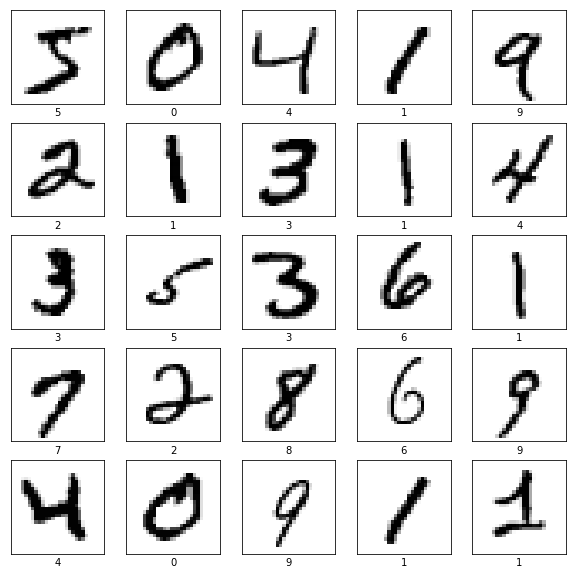

In [65]:
# Show the first 25 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

## Train a TensorFlow model to classify digit images
We use Keras API to build a TensorFlow model that can classify the digit images. Please see this [tutorial](https://www.tensorflow.org/tutorials/keras/basic_classification) if you are interested to learn more about how to build machine learning model with Keras and TensorFlow.

In [0]:
# Define the model architecture
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),

# Optional: You can replace the fully-connected layer above with the convolution layers below
    # keras.layers.Reshape(target_shape=(28, 28, 1)),
    # keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
    # keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    # keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # keras.layers.Dropout(0.25),
    # keras.layers.Flatten(input_shape=(28, 28)),
    # keras.layers.Dense(128, activation=tf.nn.relu),
    # keras.layers.Dropout(0.5),

    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# Train the digit classification model
model.fit(train_images, train_labels, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 71us/sample - loss: 0.2533 - accuracy: 0.9258
Epoch 2/5
60000/60000 [==============================] - 4s 68us/sample - loss: 0.1129 - accuracy: 0.9677
Epoch 3/5
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0793 - accuracy: 0.9762
Epoch 4/5
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0601 - accuracy: 0.9817
Epoch 5/5
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0454 - accuracy: 0.9857


## Evaluate our model 
We run our digit classification model against our test dataset that the model hasn't seen in during its training process so confirm that the model didn't just remember the digits it saw but also generalize well to new images.

In [0]:
# Evaluate the model using test dataset.
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 50us/sample - loss: 0.0766 - accuracy: 0.9757
Test accuracy: 0.9757


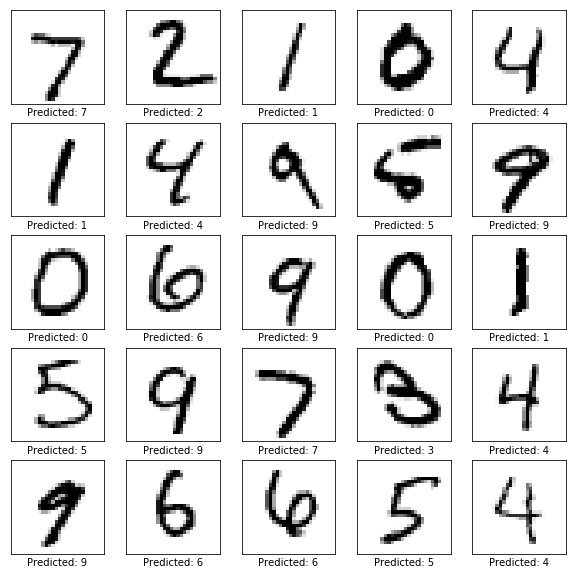

In [0]:
# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)

# Then plot the first 25 test images and their predicted labels.
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel('Predicted: %d' % np.argmax(predictions[i]))
plt.show()

## Convert the model to TensorFlow Lite

In [0]:
# Convert Keras model to TF Lite format. If you Estimator 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model as file
f = open('model.tflite', "wb")
f.write(tflite_model)
f.close()

In [0]:
# Download the digit classification model
from google.colab import files
files.download('model.tflite')

## Verify that the TensorFlow Lite model

In [72]:
# Download a test image
!wget -q https://raw.githubusercontent.com/khanhlvg/DigitClassifier/master/images/zero.png
image = keras.preprocessing.image.load_img(
    'zero.png',
    color_mode = 'grayscale',
    target_size=(28, 28),
    interpolation='bilinear'
)
image

In [0]:
# Pre-process the image: convert from RGB to grayscale (0: white, 1: black) to match with MNIST dataset format
input_image = 1.0 - np.expand_dims(np.array(image, dtype=np.float32) / 255.0, 0)

In [71]:
# Run inference with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
interpreter.set_tensor(interpreter.get_input_details()[0]["index"], input_image)
interpreter.invoke()
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])()[0]

# Print the model's classification result
digit = np.argmax(output)
print('Predicted Digit: %d\nConfidence: %f' % (digit, output[digit]))

Predicted: 0
Confidence: 0.999964
